#Generation d image
J ai laisse le code utilise pour generer les images (mais ca prend du temps),
mais il est aussi possible de charger des images deja generer.

In [1]:
from pymatbridge import Matlab
# c est une librairy speciale (A installer avec pip)

In [2]:
mlab = Matlab(executable='/home/jarbona/matlab/matlab/R2014a/bin/matlab')

In [3]:
mlab.start()

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-302ff478-e8a9-4b80-b3fa-9e1a21d57b10
Send 'exit' command to kill the server
.....MATLAB started and connected!


In [84]:
mlab.stop()

MATLAB closed


True

In [4]:
mlab.run_code("addpath('/home/jarbona/test-pil//andrei/')")

{u'content': {u'datadir': u'/tmp/MatlabData/', u'figures': [], u'stdout': u''},
 u'result': [],
 u'success': True}

In [5]:
"""
with open("andrei/SP_PSF_generation.m","r") as f:
    for el in f.readlines():
    
        #print el
        r = mlab.run_code(el)
        if r["success"] == False:
            print el 
            print r"""
with open("andrei/SP_PSF_generation.m","r") as f:   
    print mlab.run_code("".join(f.readlines()))
#with open("andrei/init.m","r") as f:
#    
#    print mlab.run_code("".join(f.readlines()))
#

{u'content': {u'stdout': u'Error: The input character is not valid in MATLAB statements or expressions.'}, u'result': u'', u'success': False}


{u'content': {u'datadir': u'/tmp/MatlabData/', u'figures': [], u'stdout': u''}, u'result': [], u'success': True}
(32, 32)


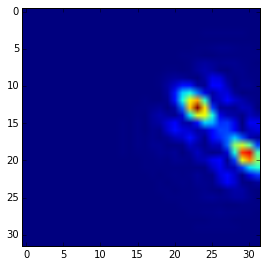

In [6]:
A = mlab.run_code("V=gaussianfft2(9,0.1,{x},{y},{z});".format(z=720,x=1,y=0))
print A
s=240
print mlab.get_variable('V')[s:-s,s:-s].shape
imshow(mlab.get_variable('V')[s:-s,s:-s])

(8000, 1, 32, 32) (8000, 3)


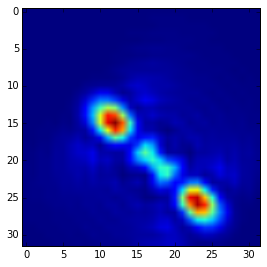

In [7]:
from tool_image import gaussian
Ddelta = []
fail = 0
N=10000
nd=16
depth=1
Nmax=10
Image , Pos =[],[]
for i in range(N):
    test = np.zeros((depth,2*nd,2*nd))
  
    #pos = np.zeros((Nmax,2))
    pos = []
    nr = np.random.randint(1,Nmax)            

    for i in range(1):
        cx,cy = np.random.rand(2)
        rescale = lambda x: 1*(1-2*x)
        cx = rescale(cx)
        cy= rescale(cy)
        z = np.random.rand()
        rescalez = lambda x: 2000*(1-2*x)
        z = rescalez(z)
        intensity = np.random.randint(500,10000)
        intensity=10000
        #print nr
        for d in range(depth):
            mlab.run_code("V=gaussianfft2(9,0.1,{x},{y},{z});".format(z=z,x=cx,y=cy))
            V = mlab.get_variable('V')[s:-s,s:-s]
            test[d] +=V      #                  500*np.random.rand(2*nd+1,2*nd+1)
        
        
        pos =[cx,cy,z]
        #pos[nr,0] = cx
        #pos[nr,1] = cy
    
    Image.append(test)
    Pos.append(pos)
    #print test.shape

Image = np.array(Image)
Pos = np.array(Pos)
train = int(0.8*N)
X_train,y_train=Image[:train],Pos[:train]
X_test,y_test=Image[train:],Pos[train:]
print X_train.shape , y_train.shape
imshow(X_train[0,0])
#figure()
#imshow(y_train[0])


(2000, 1, 32, 32)


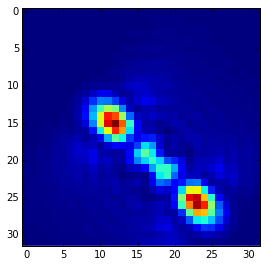

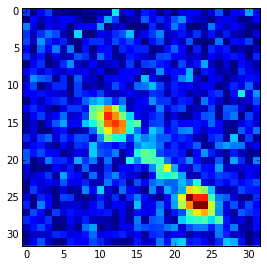

In [195]:
def noisy(img,gauss=2.,maxi=1000):
    img1 = img.copy()
    img1 /= img.max()
    noise =  np.random.normal(gauss,gauss,img1.shape)
    noise[noise < 0] = 0
    img1 += noise
    img1 *= maxi
    img1 = np.random.poisson(img1)
    return img1 / (1.0 * np.sum(img1))
imshow(X_train[0,0],interpolation="None")
figure()
imshow(noisy(X_train[0,0],gauss=0.1),interpolation="None")
print X_test.shape
#Max normalised to 1
#additive gaussian noise with mean 2
#Mutiply by 1000
#poissonise

In [ ]:
    img1 = np.random.poisson

In [ ]:
    img1 = np.random.poisson

In [ ]:
    img1 += np.random.normal

In [116]:
import cPickle
print Image.shape
with open("test_images_0.pick","w") as f:
    cPickle.dump([Image[:3000],Pos[:3000]],f)
    
with open("test_images_1.pick","w") as f:
    cPickle.dump([Image[3000:6000],Pos[3000:6000]],f)
with open("test_images_2.pick","w") as f:
    cPickle.dump([Image[6000:],Pos[6000:]],f)

(10000, 1, 32, 32)


##To load the training set:

(8000, 1, 32, 32) (8000, 3)


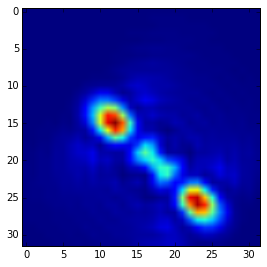

In [119]:
Image = np.zeros((10000, 1, 32, 32))
Pos = np.zeros((10000, 3))
import cPickle
with open("test_images_0.pick","r") as f:
    [Image0,Pos0] = cPickle.load(f)
    Image[:3000] = Image0
    Pos[:3000] = Pos0
with open("test_images_1.pick","r") as f:
    [Image1,Pos1] = cPickle.load(f)
    Image[3000:6000] = Image1
    Pos[3000:6000] = Pos1
with open("test_images_2.pick","r") as f:
    [Image2,Pos2] = cPickle.load(f)
    Image[6000:] = Image2
    Pos[6000:] = Pos2
N=10000
train = int(0.8*N)
X_train,y_train=Image[:train],Pos[:train]
X_test,y_test=Image[train:],Pos[train:]
print X_train.shape , y_train.shape
imshow(X_train[0,0])

#Premier test avec un layer trop gros

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD

d = 2*nd
nfilter=30
model = Sequential()
model.add(Convolution2D(nfilter, depth, d, d, border_mode='full')) 
print nfilter, depth, d, d
model.add(Activation('relu'))
model.add(Convolution2D(nfilter, nfilter, d, d))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(d*d*nfilter,3))
model.compile(loss='mean_squared_error', optimizer="rmsprop")#optimizer=sgd)


30 1 32 32


Using gpu device 0: GeForce GTX 660


In [52]:
#model.load_weights("test_a")
model.load_weights("test_drop18")   #19

In [58]:
for i in range(10):
    model.fit(X_train, y_train, batch_size=40, nb_epoch=10, validation_split=0.05,verbose=1)
    model.save_weights("test_drop%i"%(i+20))

Train on 7600 samples, validate on 400 samples
Epoch 0
7600/7600 [==============================] - 427s - loss: 0.0030 - val. loss: 0.0006
Epoch 1
7600/7600 [==============================] - 427s - loss: 0.0028 - val. loss: 0.0014
Epoch 2
7600/7600 [==============================] - 427s - loss: 0.0029 - val. loss: 0.0021
Epoch 3
7600/7600 [==============================] - 427s - loss: 0.0029 - val. loss: 0.0006
Epoch 4
7600/7600 [==============================] - 427s - loss: 0.0029 - val. loss: 0.0019
Epoch 5
7600/7600 [==============================] - 427s - loss: 0.0030 - val. loss: 0.0021
Epoch 6
7600/7600 [==============================] - 427s - loss: 0.0030 - val. loss: 0.0019
Epoch 7
7600/7600 [==============================] - 428s - loss: 0.0030 - val. loss: 0.0016
Epoch 8
7600/7600 [==============================] - 427s - loss: 0.0030 - val. loss: 0.0018
Epoch 9
7600/7600 [==============================] - 427s - loss: 0.0028 - val. loss: 0.0010
Train on 7600 samples, 

KeyboardInterrupt: 

#Network qui marche bien:

In [70]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD

d = 10
nfilter=30
model = Sequential()
model.add(Convolution2D(nfilter, depth, d, d, border_mode='full')) 
print nfilter, depth, d, d
model.add(Activation('relu'))
model.add(Convolution2D(nfilter, nfilter, d, d, border_mode='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense((32)**2*nfilter,3))
model.compile(loss='mean_squared_error', optimizer="rmsprop")#optimizer=sgd)


30 1 10 10


##To load the best weights  and predict on the test

In [192]:
model.load_weights("test_drop_V314")   #V233 #19
Ct = np.array([noisy(img,gauss=0.1,maxi=1000) for img in X_test])
print Ct.shape
predicted = model.predict(Ct)
#predicted = model.predict( X_test)

#print predicted

(2000, 1, 32, 32)
2000/2000 [==============================] - 4s     


##Or if you want to train:

In [189]:
for i in range(5,15):
    print X_train.shape
    noisyv= np.array([noisy(img,gauss=0.1,maxi=1000) for img in X_train])
    model.fit(noisyv, y_train, batch_size=100, nb_epoch=10, validation_split=0.05,verbose=1)
    model.save_weights("test_drop_V3%i"%(i))

(8000, 1, 32, 32)
Train on 7600 samples, validate on 400 samples
Epoch 0
7600/7600 [==============================] - 81s - loss: 0.0043 - val. loss: 0.0051
Epoch 1
7600/7600 [==============================] - 81s - loss: 0.0042 - val. loss: 0.0025
Epoch 2
7600/7600 [==============================] - 81s - loss: 0.0042 - val. loss: 0.0040
Epoch 3
7600/7600 [==============================] - 83s - loss: 0.0042 - val. loss: 0.0033
Epoch 4
7600/7600 [==============================] - 81s - loss: 0.0040 - val. loss: 0.0022
Epoch 5
7600/7600 [==============================] - 81s - loss: 0.0043 - val. loss: 0.0074
Epoch 6
7600/7600 [==============================] - 81s - loss: 0.0042 - val. loss: 0.0031
Epoch 7
7600/7600 [==============================] - 82s - loss: 0.0040 - val. loss: 0.0022
Epoch 8
7600/7600 [==============================] - 81s - loss: 0.0040 - val. loss: 0.0037
Epoch 9
7600/7600 [==============================] - 81s - loss: 0.0041 - val. loss: 0.0062
(8000, 1, 32, 3

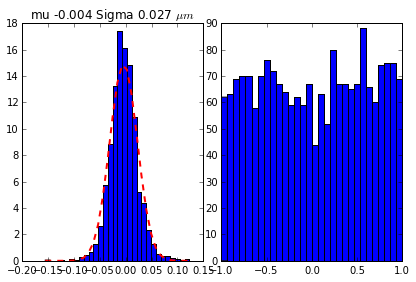

In [196]:
from scipy.stats import norm
import matplotlib.mlab as mlab
f = figure()
ax = f.add_subplot(121)
n, bins, patches = hist(predicted[::,0]-y_test[::,0],bins=30,normed=True)
(mu, sigma) = norm.fit(predicted[::,0]-y_test[::,0])
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
title("mu %.3f Sigma %.3f $\mu m$"%(mu,sigma))
ax = f.add_subplot(122)
a = hist(y_test[::,0],bins=30)


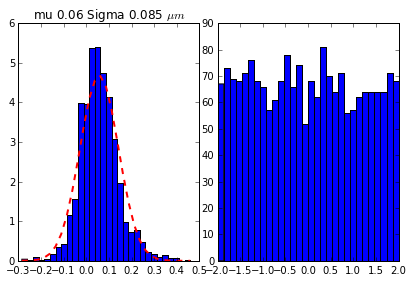

In [194]:
f = figure()
ax = f.add_subplot(121)
n, bins, patches = hist(predicted[::,2]-y_test[::,2],bins=30,normed=True)
(mu, sigma) = norm.fit(predicted[::,2]-y_test[::,2])
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
title("mu %.2f Sigma %.3f $\mu m$"%(mu,sigma))
ax = f.add_subplot(122)
a = hist(y_test[::,2],bins=30)


In [96]:
Res =[[],[],[]]
#Res =Res.tolist()
for i in range(0,37):
    model.load_weights("test_drop_V2%i"%i)   #19
    predicted = model.predict(X_test)
    for x in range(3):
        #r = 
        #r=(mu, sigma)
        Res[x].append(norm.fit(predicted[::,x]-y_test[::,x]))


2000/2000 [==============================] - 3s     


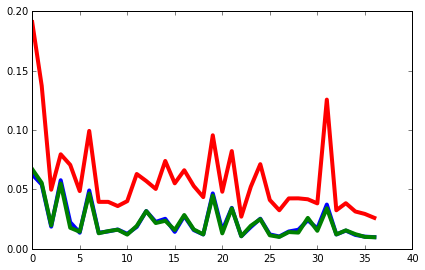

In [97]:
Res = np.array(Res)
plot(Res[0,::,1])
plot(Res[1,::,1])
plot(Res[2,::,1])

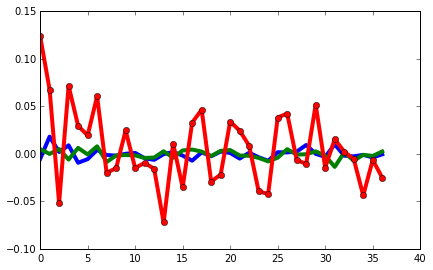

In [106]:
Res = np.array(Res)
plot(Res[0,::,0])
plot(Res[1,::,0])
plot(Res[2,::,0],"-o")

In [73]:
print X_test.shape
predicted = model.predict(X_test)

(2000, 1, 32, 32)
2000/2000 [==============================] - 3s     
